In [52]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random

random.seed(42)

In [87]:
BASE_DIR = "Warp-D"

# Labels are in train/labels/(file_name).txt in the format: class x_center y_center width height
labels_dir = os.path.join(BASE_DIR, "train/labels")
labels = os.listdir(labels_dir)

# Load the labels into a pandas dataframe
df = pd.DataFrame(columns=["file_name", "class", "x_center",
              "y_center", "width", "height"])
print(labels)

def load_df(labels_dir):
  df = pd.DataFrame(columns=["file_name", "class", "x_center",
              "y_center", "width", "height"])
  for label in labels:
    with open(os.path.join(labels_dir, label), "r") as f:
      lines = f.readlines()
      for line in lines:
        line = line.strip().split(" ")
        if len(line) != 5:
          continue
        
        new_row = {"file_name": label.split(".")[0], 
              "class": line[0],
              "x_center": line[1], 
              "y_center": line[2], 
              "width": line[3], 
              "height": line[4]}
        
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
  return df

df = load_df(labels_dir)
print(df)

['prepared_data_all_MGS_19-Oct_22-03-50.txt', 'prepared_data_all_MGS_19-Oct_19-20-46.txt', 'Robo_25-Mar_12-03-19.txt', 'prepared_data_all_MGS-27-Oct_08-59-24.txt', 'Monitoring_photo3_03-Mar_20-10-34.txt', 'Monitoring_photo3_03-Mar_20-19-38.txt', 'POSAD_1_13-Sep_04-00-35.txt', 'prepared_data_all_MGS-28-Oct_00-00-06.txt', 'prepared_data_all_MGS-27-Oct_09-04-36.txt', 'POSAD_1_11-Sep_16-52-52.txt', 'prepared_data_all_MGS_19-Oct_22-25-54.txt', 'prepared_data_all_MGS-27-Oct_08-30-45.txt', 'prepared_data_all_MGS-27-Oct_14-02-04.txt', 'prepared_data_all_MGS_19-Oct_21-32-44.txt', 'POSAD_1_12-Sep_15-46-25.txt', 'prepared_data_all_MGS-27-Oct_23-47-56.txt', 'prepared_data_all_MGS-28-Oct_01-57-49.txt', 'POSAD_1_13-Sep_04-42-04.txt', 'SPB_25-Mar_10-59-33.txt', 'POSAD_1_11-Sep_18-28-44.txt', 'Robo_25-Mar_12-13-34.txt', 'Monitoring_photo_04-Mar_05-01-32.txt', 'prepared_data_all_MGS-28-Oct_00-10-03.txt', 'prepared_data_all_MGS-27-Oct_17-05-05.txt', 'prepared_data_all_MGS_19-Oct_23-29-37.txt', 'prepared

(540, 960, 3)
                    file_name class  x_center  y_center     width    height
1155  POSAD_1_11-Sep_09-43-28     2  0.410417  0.776852  0.197917  0.235185
1156  POSAD_1_11-Sep_09-43-28     8  0.360938  0.223148  0.095833  0.138889
1157  POSAD_1_11-Sep_09-43-28     4  0.472396  0.933796  0.119792  0.132407


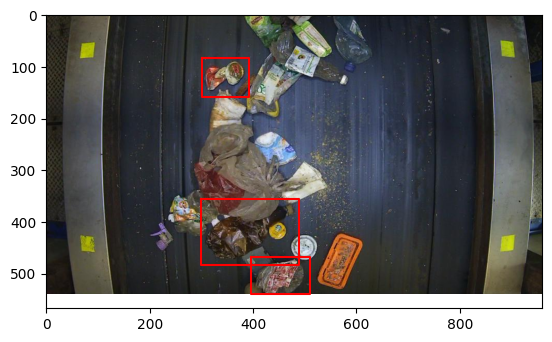

In [92]:
# Load example image and display
img_name = "POSAD_1_11-Sep_09-43-28"
img = plt.imread(os.path.join(BASE_DIR, "train/images/", img_name + ".jpg"))
plt.imshow(img)

# Filter the dataframe to only include the bounding boxes for the image we loaded
img_boxes = df[df["file_name"] == img_name]

print(img.shape)
print(img_boxes)

# Display bounding boxes
def disp_bb(img, img_boxes):
  for index, row in img_boxes.iterrows():
    # Values are normalized
    x_center = float(row["x_center"]) * img.shape[1]
    y_center = float(row["y_center"]) * img.shape[0]
    width = float(row["width"]) * img.shape[1]
    height = float(row["height"]) * img.shape[0]
    
    x1 = x_center - width/2
    x2 = x_center + width/2
    y1 = y_center - height/2
    y2 = y_center + height/2
    
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")

disp_bb(img, img_boxes)

plt.show()

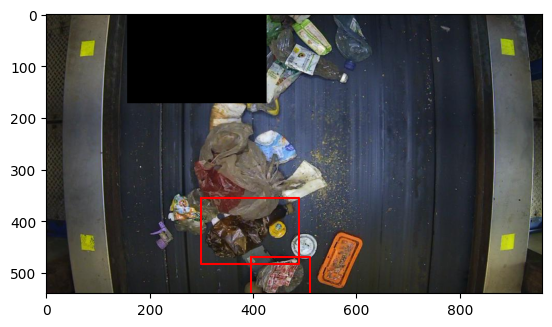

In [93]:
random.seed(43)

def cutout(img, img_boxes):
  img = np.copy(img)

  height, width = img.shape[0], img.shape[1]
  rect_height = rect_width = int(height * 0.5) # size of the rectangle

  # Random point in image
  center_y = random.randint(0, height)
  center_x = random.randint(0, width)

  # top left, bottom right
  start_y = center_y - rect_height // 2
  start_x = center_x - rect_width // 2
  end_y = start_y + rect_height
  end_x = start_x + rect_width

  # loop through rectangle coords
  for y in range(start_y, end_y):
      for x in range(start_x, end_x):
          if 0 <= y < height and 0 <= x < width:
              img[y, x] = [0, 0, 0]

  # Corners of our rectangle
  # print(start_x, start_y, end_x, end_y)

  # Loop through bounding boxes and calculate overlapping area
  for index, row in img_boxes.iterrows():
    x_center = float(row["x_center"]) * img.shape[1]
    y_center = float(row["y_center"]) * img.shape[0]
    width = float(row["width"]) * img.shape[1]
    height = float(row["height"]) * img.shape[0]

    x1 = x_center - width/2
    x2 = x_center + width/2
    y1 = y_center - height/2
    y2 = y_center + height/2

    # Calculate overlapping area
    overlap_x1 = max(x1, start_x)
    overlap_x2 = min(x2, end_x)
    overlap_y1 = max(y1, start_y)
    overlap_y2 = min(y2, end_y)

    # If there is an overlap of 50%, remove the bounding box
    overlap_pct = (overlap_x2 - overlap_x1) * (overlap_y2 - overlap_y1) / ((x2 - x1) * (y2 - y1))
    if overlap_pct > 0.5:
      img_boxes = img_boxes.drop(index)
      # print("Removing bounding box", overlap_pct)

  return img, img_boxes

# Apply cutout
img = plt.imread(os.path.join(BASE_DIR, "train/images/", img_name + ".jpg"))
img, img_boxes = cutout(img, img_boxes)


# Display bounding boxes
disp_bb(img, img_boxes)

plt.imshow(img)

In [83]:
from tqdm import tqdm

AUG_DIR = "Warp-D-Cutout"

# Loop through dataset and apply cutout
# For both test, train
for split in ["train", "test"]:
  images_dir = os.path.join(BASE_DIR, split, "images")
  images_aug_dir = os.path.join(AUG_DIR, split, "images")
  images = os.listdir(images_dir)

  for image in tqdm(images, desc=f"Processing {split} set"):
    img = plt.imread(os.path.join(images_dir, image))
    img, boxes = cutout(img, df[df["file_name"] == image.split(".")[0]])
    plt.imsave(os.path.join(images_aug_dir, image), img)
    # Save bounding boxes to txt
    # Drop the first column
    boxes = boxes.drop(columns=["file_name"])
    boxes.to_csv(os.path.join(AUG_DIR, split, "labels", image.split(".")[0] + ".txt"), header=False, index=False, sep=" ")

print("Finished processing")


Processing test set: 100%|██████████| 522/522 [00:43<00:00, 11.93it/s]

Finished processing


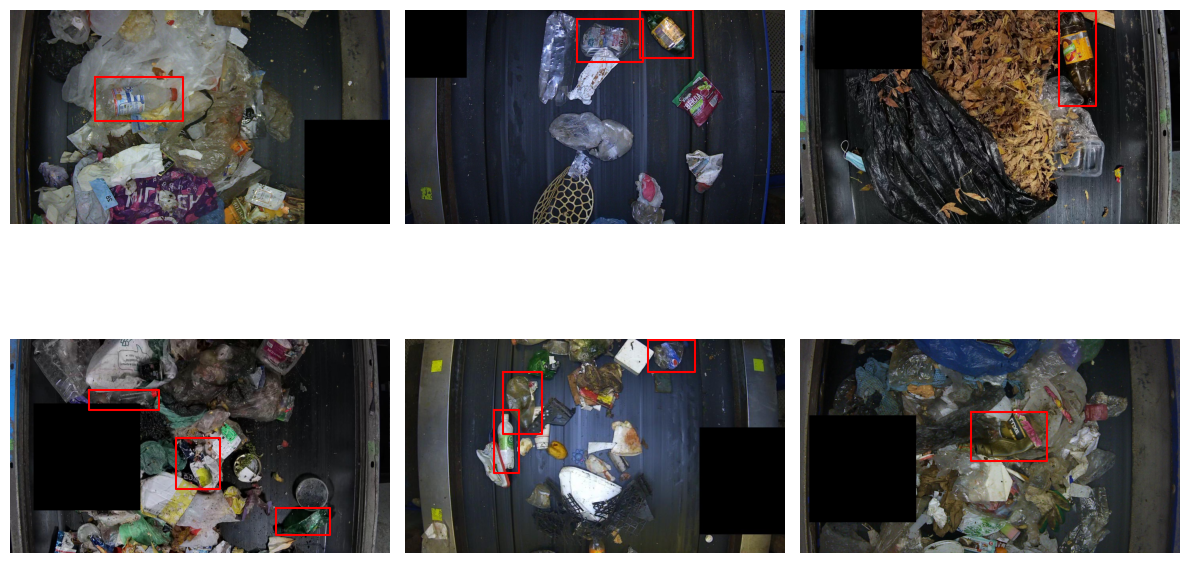

In [94]:
# Load example image and display
img_names = os.listdir(os.path.join(AUG_DIR, "train/images"))[:6]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, img_name in enumerate(img_names):
  img = plt.imread(os.path.join(AUG_DIR, "train/images/", img_name))
  axs[i].imshow(img)
  
  img_boxes = df[df["file_name"] == img_name.split(".")[0]]
  
  for index, row in img_boxes.iterrows():
    # Normalisation
    x_center = float(row["x_center"]) * img.shape[1]
    y_center = float(row["y_center"]) * img.shape[0]
    width = float(row["width"]) * img.shape[1]
    height = float(row["height"]) * img.shape[0]

    x1 = x_center - width/2
    x2 = x_center + width/2
    y1 = y_center - height/2
    y2 = y_center + height/2

    axs[i].plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")

  axs[i].axis('off')  # Remove the axes

plt.tight_layout()
plt.show()